This notebook will look at some internal wave speed theory. I will try to pick out things like the phase speed of the waves in the surface layer and slope of internal wave beams...

In [1]:
import netCDF4 as nc
import numpy as np

from salishsea_tools.nowcast import analyze

import datetime

# Some theory

## Constant buoyancy frequency

Dispersion relation of internal waves (Kundu, 2003).

$m^2 = \frac{k^2(N^2-\omega^2)}{\omega^2-f^2} $

where $m$ is the vertical wave number, $k$ is the horizontal wave number, $\omega$ is the wave frequency, $N$ is the buoyancy frequency, and $f$ is the interial frequency. This can be simplifed in certain regimes of $\omega$ wrt to $N$ and $f$, but given that a I don't know $N$ yet I will just keep going with this.

Assuming a modal decomposition, where $m = \frac{n\pi}{H}$ and $n=1,2,....$ for the mode and $H$ is the depth of the domain, I could figure out a vertical and horizontal wavelength for each mode at say the $M_2$ frequency. I just need $H$ and $N$. I will use the model results to estimate $N$ and $H$. 

But, I don't think the baroclinic currents we see in the surface layer are caused by this kind of wave. The surface is more like a two-layer stratification! Nonetheless, I still think it is a worthwhile exercise to calculate these values and also the slope of the internal wave beams:

$slope = \sqrt{\frac{\omega^2 - f^2}{N^2-\omega^2}}$.

Can we see internal wave beams at this slope in the model?


## Two layer stratification

Linear long wave speed in a two-layer stratification (Helfrich and Melville, 2006):

$c_0 = \sqrt{2g\frac{\rho_2 - \rho_1}{\rho_2 + \rho_1}\frac{h_1h_2}{h_1+h_2}}$

where $\rho_1$ and $h_1$ are the density and thickness of the upper layer, $\rho_2$ and $h_2$ are the density and thickness of the lower layer, and $g$ is the acceleration due to gravity.

Since $c = \omega/k$, I can figure out a horizontal wave length for the waves at the $M_2$ frequency. I just need $\rho_1$, $\rho_2$, $h_1$ and $h_2$ which I can estimate from the model.

Then, I could look at the changes in phase across the domain and see if the speed suggested by the changes in phase is in line with my predictions.  

In [2]:
def calculate_density(t, s):
    """Caluclates the density given temperature in deg C (t)
    and salinity in psu (s).

    returns the density as an array (rho)
    """

    rho = (
        999.842594 + 6.793952e-2 * t
        - 9.095290e-3 * t*t + 1.001685e-4 * t*t*t
        - 1.120083e-6 * t*t*t*t + 6.536332e-9 * t*t*t*t*t
        + 8.24493e-1 * s - 4.0899e-3 * t*s
        + 7.6438e-5 * t*t*s - 8.2467e-7 * t*t*t*s
        + 5.3875e-9 * t*t*t*t*s - 5.72466e-3 * s**1.5
        + 1.0227e-4 * t*s**1.5 - 1.6546e-6 * t*t*s**1.5
        + 4.8314e-4 * s*s
        )

    return rho

In [3]:
def calculate_buoyancy_frequency(temp, sal, e3, depth_axis=1):
    """ Calculate the squared buoyancy frequency (n2) given temperature and
    salinity profiles. N2 is set to  g*drho/dz/rho. Note that NEMO uses a 
    defintion based on an equation of state:   
    g* (alpha dk[T] + beta dk[S] ) / e3w

    temp and sal are the temperature and salinity arrays
    e3 is an array of the vertical scale factors (grid spacing). Use e3w for
    constistency with NEMO.
    depth_axis defines the axis which corresponds to depth in the temp/sal
    arrays

    returns n2, an array of square buoyancy frequency at each point in temp/sal.
    """

    # acceleration due to gravity
    g = 9.80665

    # First calculate density.
    rho = calculate_density(temp, sal)

    # Density gradient
    drho = np.zeros(rho.shape)
    # roll depth axis in rho and drho to first axis
    # assume e3 already has depth axis in first axis
    drho_r = np.rollaxis(drho, depth_axis)
    rho_r = np.rollaxis(rho, depth_axis)
    for k in np.arange(1, drho.shape[depth_axis]-1):
        drho_r[k, ...] = 1/e3[k, ...]*(rho_r[k+1, ...] - rho_r[k, ...])
    # Unroll drho
    drho = np.rollaxis(drho_r, 0, depth_axis+1)
    rho = np.rollaxis(rho_r, 0, depth_axis+1)
    # Define N2
    n2 = g*drho/rho  # no negative because depth increases with increasking k

    return n2

Plan: look at some snapshots of density and N2 in the CODAR region over the time I calculated the tides. 
* Does it make sense to avergae over that whole time period?
* Is there a representative grid point (VENUS central say)?

I didn't save my T/S in the model time series. I don't think it will take too long to load the daily averages.

In [4]:
to = datetime.datetime(2014, 11, 26)
tf = datetime.datetime(2015, 4, 26)
jmin = 379
jmax = 461
imin = 236
imax = 321
jss = np.arange(jmin, jmax)
iss = np.arange(imin, imax)
ks = np.arange(0,40)

files = analyze.get_filenames(to, tf, '1d', 'grid_T', '/data/dlatorne/MEOPAR/SalishSea/nowcast/')

sal, times =  analyze.combine_files(files, 'vosaline',ks, jss, iss)
temp, times =  analyze.combine_files(files, 'votemper',ks, jss, iss)

In [5]:
rho = calculate_density(temp, sal)
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
e3w = mesh.variables['e3w'][0,:,jss,iss]
n2 = calculate_buoyancy_frequency(temp, sal, e3w)

In [6]:
lons= mesh.variables['glamt'][0,jss,iss]
lats = mesh.variables['gphit'][0,jss,iss]
depths = mesh.variables['gdept'][0,:,jss,iss]

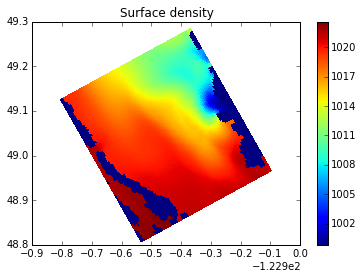

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.pcolormesh(lons, lats, rho[0,0,:,:])
plt.colorbar()
plt.title('Surface density')

In [8]:
from salishsea_tools.nowcast import research_VENUS
from salishsea_tools.nowcast import figures

In [9]:
SITES=research_VENUS.SITES['VENUS']

[jc, ic] = figures.find_model_point(SITES['Central']['lon'], SITES['Central']['lat'], lons, lats, 
                                    tol_lon=0.005, tol_lat=0.002)
[je, ie] = figures.find_model_point(SITES['East']['lon'], SITES['East']['lat'], lons, lats, 
                                    tol_lon=0.005, tol_lat=0.001)

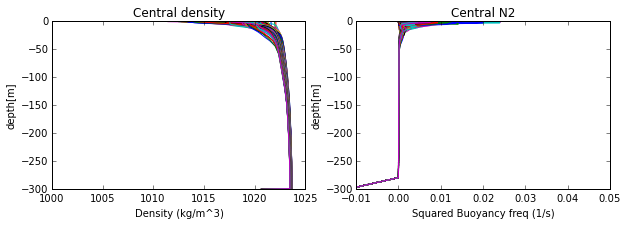

In [10]:
fig,axs = plt.subplots(1,2,figsize=(10,3))
for t in np.arange(rho.shape[0]):
    axs[0].plot( rho[t,:,jc[0],ic[0]], -depths[:,jc[0],ic[0]],)
    axs[1].plot(n2[t,:,jc[0],ic[0]], -depths[:,jc[0],ic[0]],)
ax=axs[0]
ax.set_title('Central density')
ax.set_xlim([1000,1025])
ax.set_ylim([-300, 0])
ax.set_xlabel('Density (kg/m^3)')
ax.set_ylabel('depth[m]')
ax=axs[1]
ax.set_title('Central N2')
ax.set_xlim([-.01, 0.05])
ax.set_ylim([ -300, 0])
ax.set_xlabel('Squared Buoyancy freq (1/s)')
ax.set_ylabel('depth[m]')

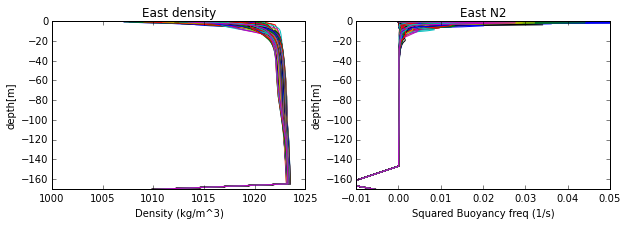

In [11]:
fig,axs = plt.subplots(1,2,figsize=(10,3))
for t in np.arange(rho.shape[0]):
    axs[0].plot( rho[t,:,je[0],ie[0]], -depths[:,je[0],ie[0]],)
    axs[1].plot(n2[t,:,je[0],ie[0]], -depths[:,je[0],ie[0]],)
ax=axs[0]
ax.set_title('East density')
ax.set_xlim([1000,1025])
ax.set_ylim([-170, 0])
ax.set_xlabel('Density (kg/m^3)')
ax.set_ylabel('depth[m]')
ax=axs[1]
ax.set_title('East N2')
ax.set_xlim([-.01, 0.05])
ax.set_ylim([ -170, 0])
ax.set_xlabel('Squared Buoyancy freq (1/s)')
ax.set_ylabel('depth[m]')

There are more sophisticated ways of doing this, but I'm just going to take the upper layer as 15m and above. 

Next - Average the buoyancy frequency and density above/below 15m

### Central

In [16]:
dep_surf = 15
central_H =280
east_H = 150

In [17]:
depc = depths[:,jc[0],ic[0]]

n2_central_deep = n2[:,np.where(np.logical_and(depc>dep_surf, depc<central_H)), jc[0], ic[0]]
n2_central_shallow = n2[:,np.where(np.logical_and(depc<dep_surf, depc>1)), jc[0], ic[0]]

rho_central_deep = rho[:,np.where(np.logical_and(depc>dep_surf, depc<central_H)), jc[0], ic[0]]
rho_central_shallow = rho[:,np.where(depc<dep_surf), jc[0], ic[0]]

print('Mean deep N2', np.mean(n2_central_deep))
print('Mean shallow N2', np.mean(n2_central_shallow))
print('Mean deep rho', np.mean(rho_central_deep))
print('Mean shallow rho', np.mean(rho_central_shallow))

Mean deep N2 0.000289294404192
Mean shallow N2 0.00195530367381
Mean deep rho 1022.6
Mean shallow rho 1020.17


Seems really small for N2...

### East

In [18]:
depe = depths[:,je[0],ie[0]]

n2_east_deep = n2[:,np.where(np.logical_and(depe>dep_surf, depe<east_H)), je[0], ie[0]]
n2_east_shallow = n2[:,np.where(np.logical_and(depe<dep_surf, depe>1)), je[0], ie[0]]

rho_east_deep = rho[:,np.where(np.logical_and(depe>dep_surf, depe<east_H)), je[0], ie[0]]
rho_east_shallow = rho[:,np.where(depe<15), je[0], ie[0]]

print('Mean deep N2', np.mean(n2_east_deep))
print('Mean shallow N2', np.mean(n2_east_shallow))
print('Mean deep rho', np.mean(rho_east_deep))
print('Mean shallow rho', np.mean(rho_east_shallow))

Mean deep N2 0.000296823508401
Mean shallow N2 0.00337408283137
Mean deep rho 1022.46
Mean shallow rho 1020.0


* Deep east N2 and density is similar to deep central. 
* East and Central have similar densities in my surface layer. Does that make sense? I would think that East is less dense.
* East is more stratified. This makes sense because it is closer to the river.
* I probably should look at standard deviation to see how variable this numbers are...

## Parameters for wave calculations
I will calculate wave parmeters at east and central separately.

In [31]:
h1={}
h2={}
rho1={}
rho2={}
H ={}
n2_names={}

#East
name = 'East'
H[name] = 150
h1[name] = 15
h2[name] = H[name] - h1[name]
rho1[name] = np.mean(rho_east_shallow)
rho2[name] = np.mean(rho_east_deep)
n2_names[name] = np.mean(n2_east_deep)

#East
name = 'Central'
H[name] = 280
h1[name] = 15
h2[name] = H[name] - h1[name]
rho1[name] = np.mean(rho_east_shallow)
rho2[name] = np.mean(rho_east_deep)
n2_names[name] = np.mean(n2_east_deep)

M2_freq = 2*np.pi/(12.4206*3600)
g = 9.80665
f = 2*1/(24*3600)*np.sin(np.deg2rad(49))

### Linear long wave speed
$c_0 = \sqrt{2g\frac{\rho_2 - \rho_1}{\rho_2 + \rho_1}\frac{h_1h_2}{h_1+h_2}}$

In [26]:
co={}
k = {}
lam = {}
for name in ['East', 'Central']:
    co[name] = np.sqrt( 2*g*(rho2[name]-rho1[name])/(rho2[name]+rho1[name])*h1[name]*h2[name]/(H[name]))
    k[name] = M2_freq/co[name]
    lam[name] = 2*np.pi/(k[name])/1000 #in km

In [29]:
co #in m/s

{'Central': 0.53928945548873375, 'East': 0.52589526697449462}

In [30]:
lam #in km

{'Central': 24.113874999036121, 'East': 23.514965110740267}

How do these values comapre to what an observationalist would get? At least I've confirmed that the model can resolve these waves horizontally. 

Not much variation between Central and East.

This is complicated because the actual waves would interact with the mean current. I need to figure out directions of propagation etc. 

This wave lengths are interesting because this is about the width of the Strait of Gerogia.

### Constant N
$slope = \sqrt{\frac{\omega^2 - f^2}{N^2-\omega^2}}$.

In [35]:
slope = {}
for name in ['East','Central']:
    slope[name] = np.sqrt((M2_freq**2 - f**2)/(n2_names[names] - M2_freq**2))

In [36]:
slope

{'Central': 0.0080931474889411967, 'East': 0.0080931474889411967}

Check in model? My estimate is (based on eyeballs of beam rise and run):

In [23]:
dx =(100-70)*500
dz = 130
dz/dx

0.008666666666666666